In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import warnings

import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

# Set display options for better output
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
plt.style.use('default')

In [28]:
# Tải dữ liệu trực tiếp
from pathlib import Path

# Định nghĩa đường dẫn
project_root = Path.cwd().parent
data_dir = project_root / "data" / "raw"

# Import trực tiếp 2 dataset
df_sentiment = pd.read_csv(data_dir / "data_sentiment.csv", encoding='utf-8')
df_summary = pd.read_csv(data_dir / "data_summary.csv", encoding='utf-8')

# Tạo dictionary để dễ xử lý
datasets = {
    'sentiment': df_sentiment,
    'summary': df_summary
}

print(f"Sentiment: {len(df_sentiment):,} hàng, {len(df_sentiment.columns)} cột")
print(f"Summary: {len(df_summary):,} hàng, {len(df_summary.columns)} cột")

Sentiment: 31,460 hàng, 4 cột
Summary: 102,681 hàng, 3 cột


In [ ]:
# Phân tích cấu trúc dataset
print("cấu trúc của các datasets")
for name, df in datasets.items():
    print(f"\nDataset {name.lower()}:")
    print(f"Kích thước: {df.shape}")
    print(f"Cột: {list(df.columns)}")
    
    display(df.head(3))

cấu trúc của các datasets

Dataset sentiment:
Kích thước: (31460, 4)
Cột: ['comment', 'label', 'rate', 'Unnamed: 3']
Bộ nhớ sử dụng: 8.27 MB


,comment,label,rate,Unnamed: 3
0,Áo bao đẹp ạ!!,POS,5,NaN
1,Tuyệt vời !,POS,5,NaN
2,2day ao khong giong trong.,NEG,1,NaN



Dataset summary:
Kích thước: (102681, 3)
Cột: ['Unnamed: 0', 'Summary', 'Text']
Bộ nhớ sử dụng: 677.06 MB


,Unnamed: 0,Summary,Text
0,0,Ngay khi bắt tay ai đó có thể chúng ta đã cảm ...,Tổng thống Mỹ Donald Trump và Tổng thống Pháp ...
1,1,"Rời khỏi Việt Nam vào 10/2016, ông Vũ Đình Duy...",Vũ Đình Duy hồi tháng 5 xuất hiện trước tòa tạ...
2,2,Thủ tướng Iraq xác nhận với BBC rằng Syria khô...,Ông Maliki xác nhận các vụ không kích của Syri...


In [21]:
# Đánh giá chất lượng dữ liệu
print("chất lượng dữ liệu")

def phan_tich_chat_luong(df, ten_dataset):
    print(f"\nDataset {ten_dataset.lower()}:")
    
    # Giá trị thiếu
    missing = df.isnull().sum()
    if missing.sum() == 0:
        print("Không có giá trị thiếu")
    else:
        print("Giá trị thiếu:")
        for col in missing[missing > 0].index:
            pct = (missing[col] / len(df)) * 100
            print(f"  {col}: {missing[col]} ({pct:.1f}%)")
    
    # Hàng trùng lặp
    duplicates = df.duplicated().sum()
    duplicate_pct = (duplicates / len(df)) * 100
    print(f"Hàng trùng lặp: {duplicates} ({duplicate_pct:.1f}%)")
    
    # Phân tích cột văn bản
    text_cols = df.select_dtypes(include=['object']).columns
    print("Phân tích cột văn bản:")
    
    for col in text_cols:
        if df[col].dtype == 'object':
            empty_strings = (df[col].astype(str).str.strip() == '').sum()
            unique_count = df[col].nunique()
            avg_length = df[col].astype(str).str.len().mean()
            
            print(f"  {col}:")
            print(f"Chuỗi rỗng: {empty_strings}")
            print(f"Giá trị duy nhất: {unique_count}")
            print(f"Độ dài trung bình: {avg_length:.1f} ký tự")
    
    return {
        'missing_values': missing.sum(),
        'duplicates': duplicates,
        'total_rows': len(df)
    }

# Phân tích từng dataset
quality_reports = {}
for name, df in datasets.items():
    quality_reports[name] = phan_tich_chat_luong(df, name)

chất lượng dữ liệu

Dataset sentiment:
Giá trị thiếu:
  Unnamed: 3: 31437 (99.9%)
Hàng trùng lặp: 3982 (12.7%)
Phân tích cột văn bản:
  comment:
Chuỗi rỗng: 0
Giá trị duy nhất: 26803
Độ dài trung bình: 44.9 ký tự
  label:
Chuỗi rỗng: 0
Giá trị duy nhất: 3
Độ dài trung bình: 3.0 ký tự
  Unnamed: 3:
Chuỗi rỗng: 0
Giá trị duy nhất: 1
Độ dài trung bình: 3.0 ký tự

Dataset summary:
Giá trị thiếu:
  Text: 32 (0.0%)
Hàng trùng lặp: 0 (0.0%)
Phân tích cột văn bản:
  Summary:
Chuỗi rỗng: 0
Giá trị duy nhất: 89571
Độ dài trung bình: 140.6 ký tự
Hàng trùng lặp: 0 (0.0%)
Phân tích cột văn bản:
  Summary:
Chuỗi rỗng: 0
Giá trị duy nhất: 89571
Độ dài trung bình: 140.6 ký tự
  Text:
Chuỗi rỗng: 63
Giá trị duy nhất: 96284
Độ dài trung bình: 3231.2 ký tự
  Text:
Chuỗi rỗng: 63
Giá trị duy nhất: 96284
Độ dài trung bình: 3231.2 ký tự


In [23]:
# Phân tích văn bản
print("phân tích văn bản")

# Sentiment dataset
df_sent = datasets['sentiment']
comment_lengths = df_sent['comment'].astype(str).str.len()
comment_words = df_sent['comment'].astype(str).str.split().str.len()

print(f"\nDataset sentiment (comment):")
print(f"Độ dài trung bình: {comment_lengths.mean():.1f} ký tự")
print(f"Số từ trung bình: {comment_words.mean():.1f} từ")

# Summary dataset
df_summ = datasets['summary']
text_lengths = df_summ['Text'].astype(str).str.len()
summary_lengths = df_summ['Summary'].astype(str).str.len()

print(f"\nDataset summary:")
print(f"Text - Độ dài TB: {text_lengths.mean():.1f} ký tự")
print(f"Summary - Độ dài TB: {summary_lengths.mean():.1f} ký tự")
print(f"Tỷ lệ nén: {(summary_lengths.mean() / text_lengths.mean()):.3f}")

phân tích văn bản

Dataset sentiment (comment):
Độ dài trung bình: 44.9 ký tự
Số từ trung bình: 10.2 từ

Dataset summary:
Text - Độ dài TB: 3231.2 ký tự
Summary - Độ dài TB: 140.6 ký tự
Tỷ lệ nén: 0.044


In [25]:
# Phân tích sentiment
print("phân tích sentiment")

df_sent = datasets['sentiment']

# Phân phối nhãn
label_counts = df_sent['label'].value_counts()
print(f"\nPhân phối nhãn:")
for label, count in label_counts.items():
    pct = (count / len(df_sent)) * 100
    print(f"  {label}: {count:,} ({pct:.1f}%)")

phân tích sentiment

Phân phối nhãn:
  POS: 20,093 (63.9%)
  NEG: 6,669 (21.2%)
  NEU: 4,698 (14.9%)


In [26]:
# Phân tích summary
print("phân tích summary")

df_summ = datasets['summary']

# Tính toán cơ bản
text_lengths = df_summ['Text'].astype(str).str.len()
summary_lengths = df_summ['Summary'].astype(str).str.len()
text_words = df_summ['Text'].astype(str).str.split().str.len()
summary_words = df_summ['Summary'].astype(str).str.split().str.len()

compression_ratio = summary_lengths.mean() / text_lengths.mean()

print(f"\nThống kê:")
print(f"Văn bản gốc: {text_lengths.mean():.1f} ký tự, {text_words.mean():.1f} từ")
print(f"Tóm tắt: {summary_lengths.mean():.1f} ký tự, {summary_words.mean():.1f} từ")
print(f"Tỷ lệ nén: {compression_ratio:.3f}")

# Ví dụ
print(f"\nVí dụ:")
sample = df_summ.iloc[0]
print(f"Text: {str(sample['Text'])[:100]}...")
print(f"Summary: {sample['Summary']}")

phân tích summary

Thống kê:
Văn bản gốc: 3231.2 ký tự, 704.2 từ
Tóm tắt: 140.6 ký tự, 30.6 từ
Tỷ lệ nén: 0.044

Ví dụ:
Text: Tổng thống Mỹ Donald Trump và Tổng thống Pháp Emmanuel Macron đi cạnh nhau, nắm chặt tay nhau. Loại...
Summary: Ngay khi bắt tay ai đó có thể chúng ta đã cảm giác được là có cái gì đó sai sai, nhưng lại không thể biết đích xác là tại sao. Giữ tay quá lâu, nắm quá chặt, hay kéo tay khiến hai người gần sát nhau quá... những thứ đó đều có thể ảnh hưởng tới phần còn lại của cuộc gặp gỡ.

Thống kê:
Văn bản gốc: 3231.2 ký tự, 704.2 từ
Tóm tắt: 140.6 ký tự, 30.6 từ
Tỷ lệ nén: 0.044

Ví dụ:
Text: Tổng thống Mỹ Donald Trump và Tổng thống Pháp Emmanuel Macron đi cạnh nhau, nắm chặt tay nhau. Loại...
Summary: Ngay khi bắt tay ai đó có thể chúng ta đã cảm giác được là có cái gì đó sai sai, nhưng lại không thể biết đích xác là tại sao. Giữ tay quá lâu, nắm quá chặt, hay kéo tay khiến hai người gần sát nhau quá... những thứ đó đều có thể ảnh hưởng tới phần còn lại của c

CREATING VISUALIZATION DASHBOARD
Creating visualizations for sentiment dataset...
Creating visualizations for summary dataset...
Creating visualizations for news dataset...


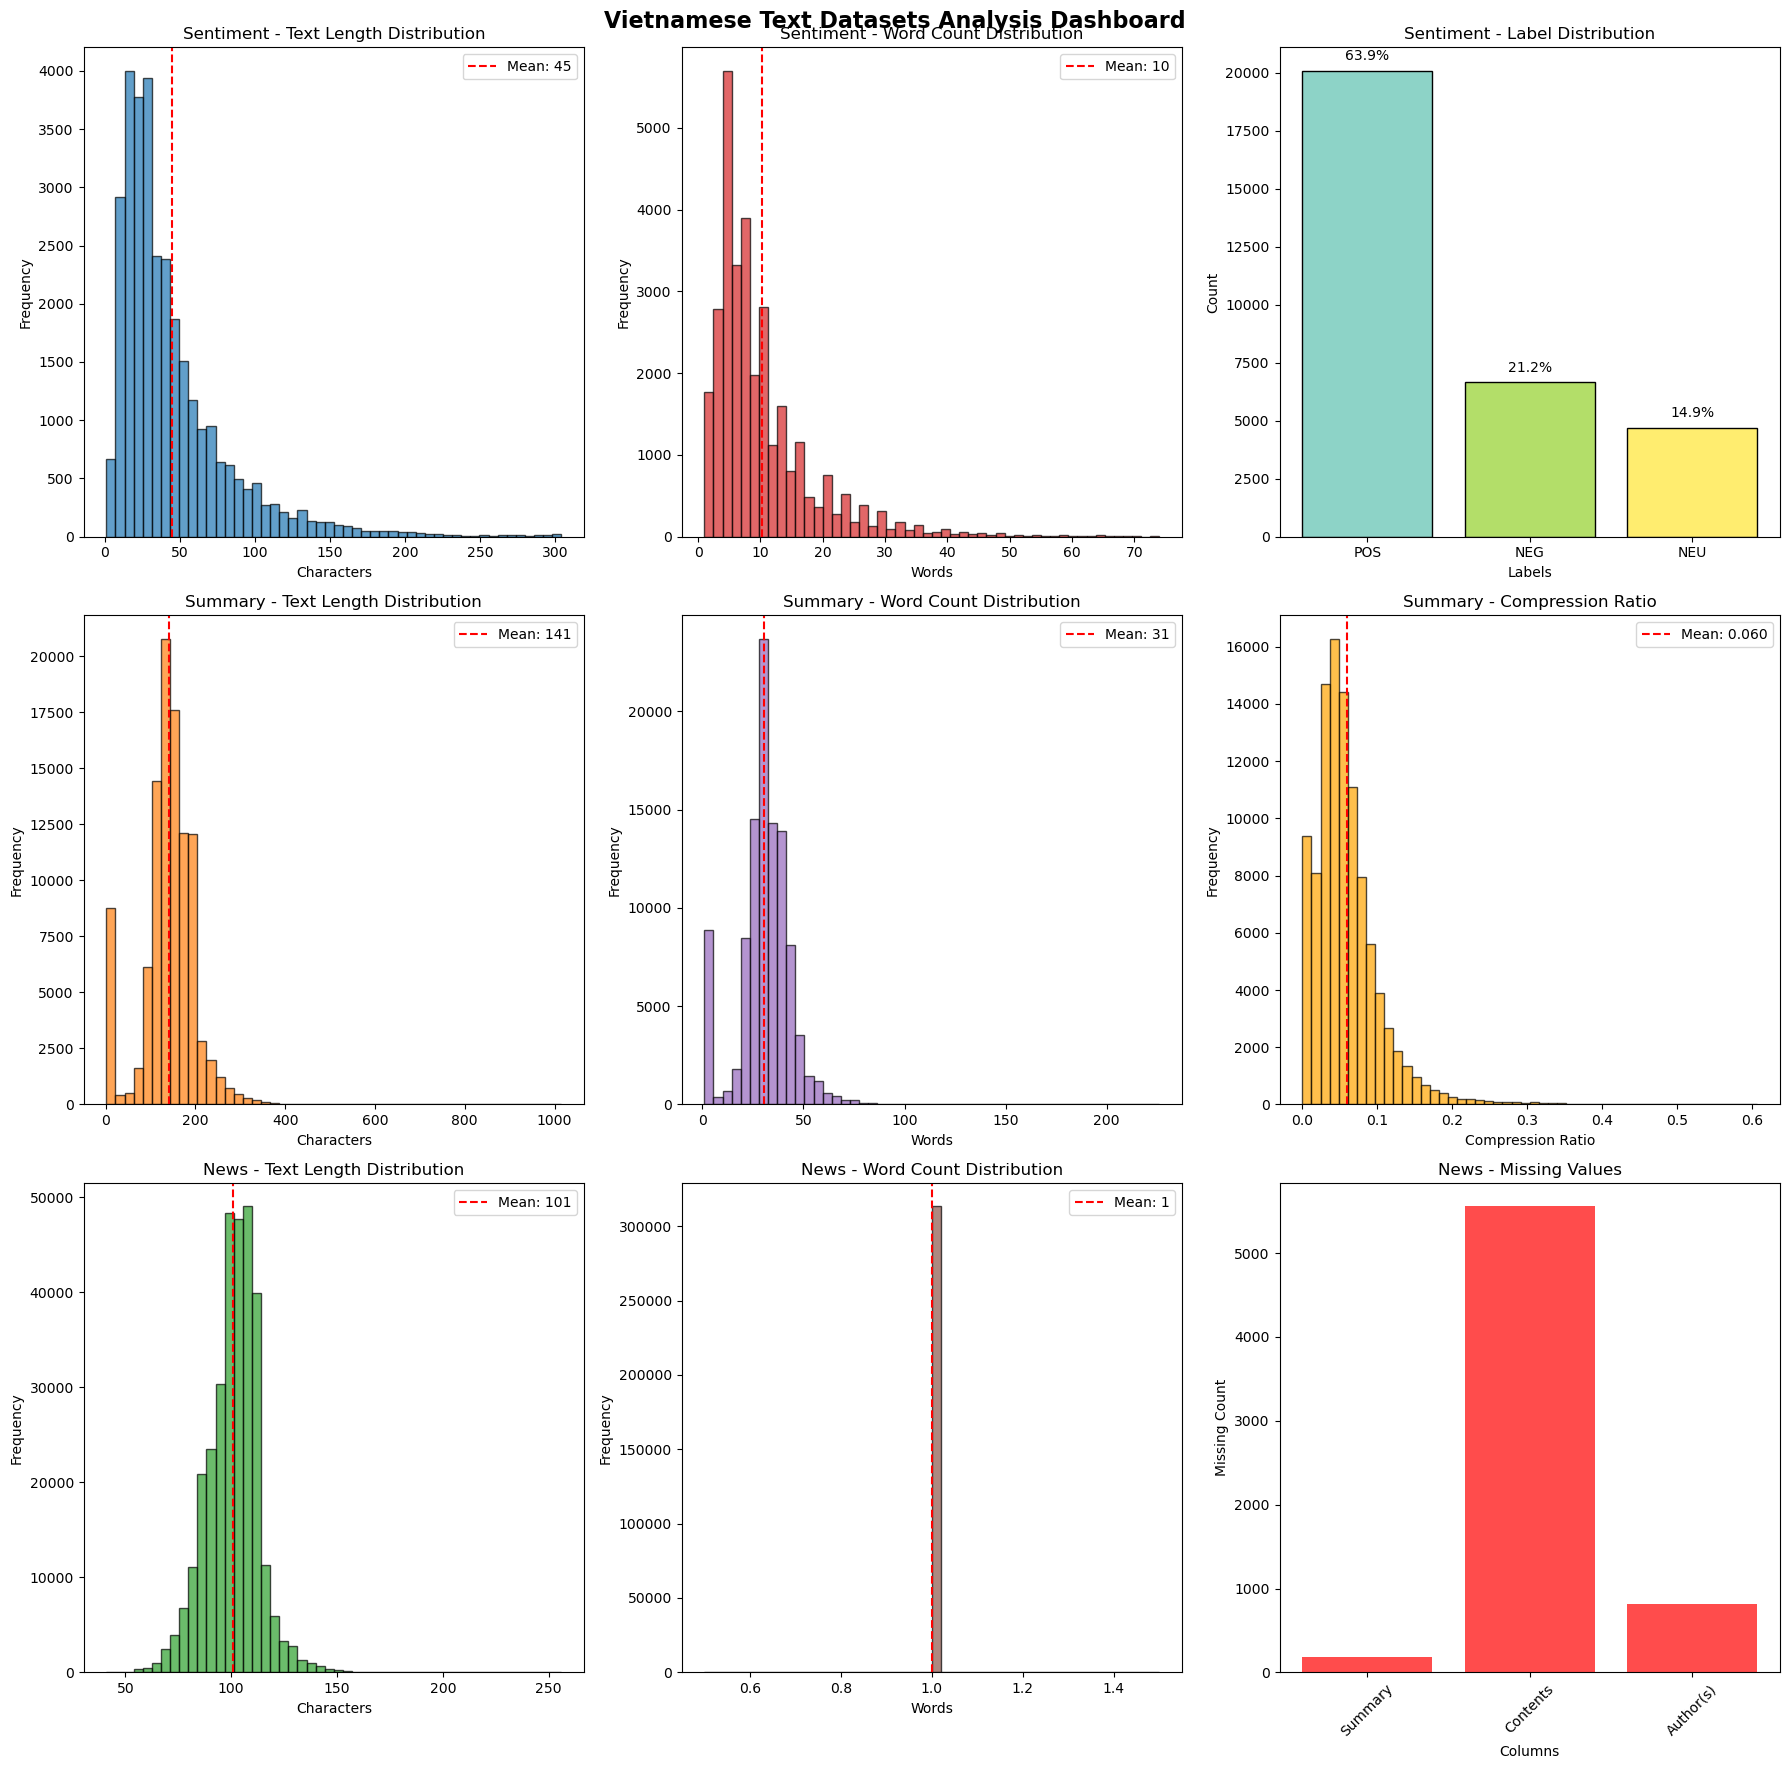

✓ Dashboard created successfully!


In [ ]:
# Biểu đồ
print("tạo biểu đồ")

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Phân tích dữ liệu', fontsize=14)

# Sentiment - độ dài comment
comment_lengths = df_sentiment['comment'].astype(str).str.len()
axes[0,0].hist(comment_lengths, bins=30, alpha=0.7, color='blue')
axes[0,0].set_title('Sentiment - Độ dài comment')
axes[0,0].set_xlabel('Ký tự')

# Sentiment - phân phối nhãn
label_counts = df_sentiment['label'].value_counts()
axes[0,1].bar(label_counts.index, label_counts.values, color=['green', 'red', 'gray'])
axes[0,1].set_title('Sentiment - Phân phối nhãn')
axes[0,1].set_ylabel('Số lượng')

# Summary - độ dài text
text_lengths = df_summary['Text'].astype(str).str.len()
axes[1,0].hist(text_lengths, bins=30, alpha=0.7, color='orange')
axes[1,0].set_title('Summary - Độ dài text')
axes[1,0].set_xlabel('Ký tự')

# Summary - tỷ lệ nén
summary_lengths = df_summary['Summary'].astype(str).str.len()
compression_ratios = summary_lengths / text_lengths
axes[1,1].hist(compression_ratios, bins=30, alpha=0.7, color='purple')
axes[1,1].set_title('Summary - Tỷ lệ nén')
axes[1,1].set_xlabel('Tỷ lệ')

plt.tight_layout()
plt.show()
print("hoàn thành")

In [ ]:
# Tổng kết
print("tổng kết")

print(f"\nSentiment: {len(df_sentiment):,} mẫu")
print(f"Summary: {len(df_summary):,} mẫu")
print(f"Tổng: {len(df_sentiment) + len(df_summary):,} mẫu")

print(f"\nKhuyến nghị:")
print(f"- Sentiment: Cần cân bằng dữ liệu (POS chiếm {(df_sentiment['label'].value_counts()['POS']/len(df_sentiment)*100):.1f}%)")
print(f"- Summary: Chất lượng tốt, tỷ lệ nén hợp lý")
print(f"- Sẵn sàng để huấn luyện mô hình")

# Bảng tóm tắt đơn giản
summary_table = pd.DataFrame({
    'Dataset': ['Sentiment', 'Summary'],
    'Số mẫu': [len(df_sentiment), len(df_summary)],
    'Số cột': [len(df_sentiment.columns), len(df_summary.columns)],
    'Trạng thái': ['Cần cân bằng', 'Sẵn sàng']
})

print(f"\nBảng tóm tắt:")
display(summary_table)

COMPREHENSIVE ANALYSIS SUMMARY REPORT

📋 DATASET SUMMARY:
  Sentiment: 31,460 samples, 4 columns
  Summary: 102,681 samples, 3 columns
  News: 313,320 samples, 8 columns

Total samples across all datasets: 447,461

🎯 RECOMMENDATIONS:

Data Quality:
  ❌ Sentiment: Address 31437 missing values
  ❌ Sentiment: High duplicate rate (12.7%) - consider deduplication
  ❌ Summary: Address 32 missing values
  ❌ News: Address 6558 missing values
  ❌ News: High duplicate rate (7.4%) - consider deduplication

Preprocessing:
  ⚠️ Sentiment.label: High rate of very short texts (100.0%)
  ⚠️ Sentiment.Unnamed: 3: High rate of very short texts (100.0%)
  ⚠️ Summary.Text: Consider text truncation for very long texts (93.9%)
  ⚠️ News.Contents: Consider text truncation for very long texts (87.5%)
  ⚠️ News.Author(s): High rate of very short texts (77.8%)
  ⚠️ News.Category: High rate of very short texts (88.6%)

Modeling:
  ❌ Sentiment: Highly imbalanced labels (ratio: 4.3:1) - consider rebalancing
  ✅ Su

,Dataset,Rows,Columns,Missing Values,Duplicates,Avg Text Length,Memory (MB)
0,Sentiment,31460,4,31437,3982,44.9,10.06
1,Summary,102681,3,32,0,140.6,695.11
2,News,313320,8,6558,23032,101.0,1880.79
